## Part 1: Wrangling

Using SQL compute a relation containing the total payroll and winning percentage (number of wins / number of games * 100) for each team (that is, for each teamID and yearID combination). You should include other columns that will help when performing EDA later on (e.g., franchise ids, number of wins, number of games).

In [163]:
import sqlite3
import pandas

sqlite_file = 'lahman2014.sqlite'
conn = sqlite3.connect(sqlite_file)

In [164]:
salary_query = """SELECT yearID, teamID, sum(salary) as total_payroll
                    FROM Salaries
                    GROUP BY yearID, teamID
"""

team_salaries = pandas.read_sql(salary_query, conn)

In [165]:
team_salaries

,yearID,teamID,total_payroll
0,1985,ATL,14807000.0
1,1985,BAL,11560712.0
2,1985,BOS,10897560.0
3,1985,CAL,14427894.0
4,1985,CHA,9846178.0
...,...,...,...
855,2014,SLN,120693000.0
856,2014,TBA,72689100.0
857,2014,TEX,112255059.0
858,2014,TOR,109920100.0


In [166]:
teams_query = """SELECT yearID, teamID, W as Wins, G as Games
                    FROM Teams 
                    GROUP BY yearID, teamID"""

team_wins = pandas.read_sql(teams_query, conn)

In [167]:
team_wins

,yearID,teamID,Wins,Games
0,1871,BS1,20,31
1,1871,CH1,19,28
2,1871,CL1,10,29
3,1871,FW1,7,19
4,1871,NY2,16,33
...,...,...,...,...
2770,2014,SLN,90,162
2771,2014,TBA,77,162
2772,2014,TEX,67,162
2773,2014,TOR,83,162


In [168]:
q1_df = pandas.merge(team_salaries, team_wins, how='left', on=['yearID', 'teamID'])
q1_df["winning_percentage"] = (q1_df["Wins"] / q1_df["Games"] *100).round(2)
q1_df.drop(["Wins", "Games"], axis=1, inplace=True)

In [169]:
q1_df

,yearID,teamID,total_payroll,winning_percentage
0,1985,ATL,14807000.0,40.74
1,1985,BAL,11560712.0,51.55
2,1985,BOS,10897560.0,49.69
3,1985,CAL,14427894.0,55.56
4,1985,CHA,9846178.0,52.15
...,...,...,...,...
855,2014,SLN,120693000.0,55.56
856,2014,TBA,72689100.0,47.53
857,2014,TEX,112255059.0,41.36
858,2014,TOR,109920100.0,51.23


## Part 2: Exploratory Data Analysis

### Payroll Distribution

#### Problem 2 (8 pts)

Write code to produce plots that illustrate the distribution of payrolls across teams conditioned on time (from 1990-2014).

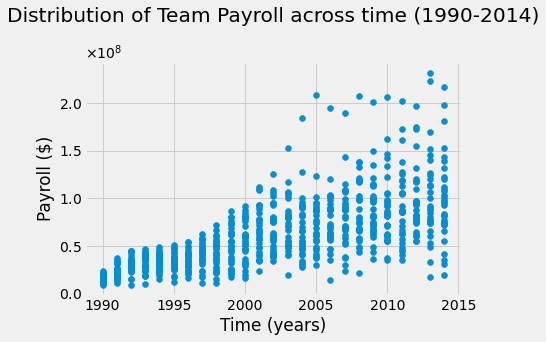

In [170]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
xfmt = ScalarFormatter(useMathText = True)
xfmt.set_powerlimits((0,8))
q2_df = q1_df.copy(deep=True)
q2_df = q2_df.loc[(q2_df["yearID"]<=2014) & (q2_df["yearID"]>=1990)]
plt.style.use('fivethirtyeight')

plt.scatter(q2_df["yearID"], q2_df["total_payroll"], label = "all")
plt.title("Distribution of Team Payroll across time (1990-2014)", pad=40)
plt.gca().yaxis.set_major_formatter(xfmt)
plt.xlabel("Time (years)")
plt.ylabel("Payroll ($)")
plt.show()

#### Question 1 (9 pts)

What statements can you make about the distribution of payrolls conditioned on time based on these plots? Remember you can make statements in terms of central tendency, spread, etc.

Mean and median payrolls have increased over time.
The spread of payrolls has increased with time, with the distributions getting more left skewed over time

#### Problem 3 (8 pts)

Write code to produce plots that specifically show at least one of the statements you made in Question 1. For example, if you make a statement that there is a trend for payrolls to decrease over time, make a plot of a statistic for central tendency (e.g., mean payroll) vs. time to show that specficially.

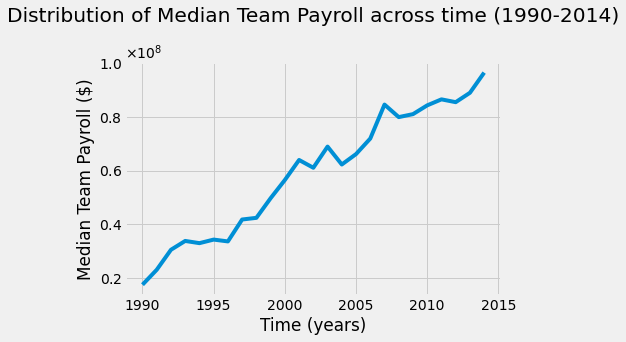

In [171]:
q3_df = q2_df.groupby('yearID', as_index=False).median()

plt.plot(q3_df["yearID"], q3_df["total_payroll"], label = "all")
plt.title("Distribution of Median Team Payroll across time (1990-2014)", pad=40)
plt.gca().yaxis.set_major_formatter(xfmt)
plt.xlabel("Time (years)")
plt.ylabel("Median Team Payroll ($)")
plt.show()

In [203]:
q3_df

,yearID,total_payroll,winning_percentage
0,1990,17590786.0,48.150
1,1991,23145583.5,51.230
2,1992,30587250.0,49.075
3,1993,33873166.5,51.075
4,1994,33049798.5,46.960
5,1995,34375642.5,48.610
6,1996,33697750.0,50.310
7,1997,41847997.0,48.770
8,1998,42469917.0,48.925
9,1999,49773187.0,47.840


#### Problem 4 (8 pts)

Write code to discretize year into five time periods (you can use [pandas.cut](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html) to accomplish this) and then make a scatterplot showing mean winning percentage (y-axis) vs. mean payroll (x-axis) for each of the five time periods. You could add a regression line (using, e.g., NumPy's [polyfit](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html)) in each scatter plot to ease interpretation.


1


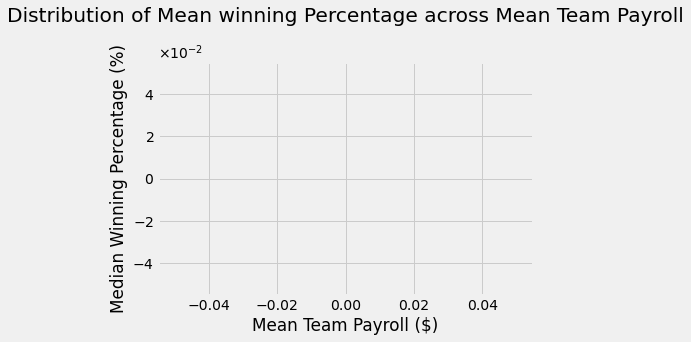

In [206]:
q4_df = q3_df.copy(deep=True)
q4_df["periods"] = pandas.cut(q2_df["yearID"], 5)
for period in q4_df["periods"].unique():
    print(1)
    # for each 5 yr period, get the mean win and payroll each year
    slice_df = q4_df[q4_df["periods"] == period]
    plt.plot(slice_df["total_payroll"], slice_df["winning_percentage"], label = "all")
    plt.title("Distribution of Mean winning Percentage across Mean Team Payroll", pad=40)
    plt.gca().yaxis.set_major_formatter(xfmt)
    plt.xlabel("Mean Team Payroll ($)")
    plt.ylabel("Median Winning Percentage (%)")
    plt.show()


# periods = pandas.cut(q2_df["yearID"], 5, retbins = True, duplicates="drop")

In [173]:
q4_df = q2_df.groupby(pandas.cut(q2_df["yearID"], 5), as_index=False)
q4_df.head()
# plt.scatter(q4_df["total_payroll"], q4_df["winning_percentage"], label = "all")
# plt.title("Distribution of Mean Winning Percentage against Mean Team Payroll across time (1990-2014)", pad=40)
# plt.gca().xaxis.set_major_formatter(xfmt)
# plt.xlabel("Mean Team Payroll ($)")
# plt.ylabel("Mean Winning Percentage")
# plt.show()

,yearID,teamID,total_payroll,winning_percentage
130,1990,ATL,14555501.0,40.12
131,1990,BAL,9680084.0,47.20
132,1990,BOS,20558333.0,54.32
133,1990,CAL,21720000.0,49.38
134,1990,CHA,9491500.0,58.02
264,1995,ATL,47235445.0,62.50
265,1995,BAL,43942521.0,49.31
266,1995,BOS,32455518.0,59.72
267,1995,CAL,31223171.0,53.79
268,1995,CHA,46961282.0,46.90


#### Question 2 (9 pts)

What can you say about team payrolls across these periods? Are there any teams that standout as being particularly good at paying for wins across these time periods? What can you say about the Oakland A's spending efficiency across these time periods (labeling points in the scatterplot can help interpretation).

## Part 3: Data transformations

### Standardizing across years

It looks like comparing payrolls across years is problematic so let's do a transformation that will help with these comparisons.

#### Problem 5 (8 pts)

Create a new variable in your dataset that standardizes payroll conditioned on year. So, this column for team `i` in year `j` should equal:

<!--
```
$ standardized\_payroll_{ij} = \frac{{payroll}_{ij} - \overline{payroll}_{j} }{{s}_{j}} $
```
-->

![](figs/prob5_alternate.png)

for team `i` in year `j`.

where <!--<em><span style="text-decoration: overline">payroll</span><sub>j</sub></em>--> <em>avg\_payroll<sub>j</sub></em> is the average payroll for year `j`, and <em>s<sub>j</sub></em> is the standard deviation of payroll for year `j`.

In [202]:
# q5_df = q1_df.copy(deep=True)
from numpy import average


q5_df = q1_df.groupby('yearID', as_index=False)["total_payroll"].agg({'average_payroll': 'mean'})
# q5_df["standardized_payroll"] = q5_df["total_payroll"]
q5_df.head(10)

,yearID,average_payroll
0,1985,1.007557e+07
1,1986,1.184056e+07
2,1987,1.048367e+07
3,1988,1.155586e+07
4,1989,1.384599e+07
5,1990,1.707235e+07
6,1991,2.357879e+07
7,1992,3.098244e+07
8,1993,3.220500e+07
9,1994,3.313701e+07


In [192]:
q1_df

,yearID,teamID,total_payroll,winning_percentage
0,1985,ATL,14807000.0,40.74
1,1985,BAL,11560712.0,51.55
2,1985,BOS,10897560.0,49.69
3,1985,CAL,14427894.0,55.56
4,1985,CHA,9846178.0,52.15
...,...,...,...,...
855,2014,SLN,120693000.0,55.56
856,2014,TBA,72689100.0,47.53
857,2014,TEX,112255059.0,41.36
858,2014,TOR,109920100.0,51.23
